# Land degradation <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[s2_12a](https://explorer.digitalearth.africa/s2_12a)

## Background

[Surface mining](https://americanmineservices.com/types-of-surface-mining) refers to the removal of the terrain surface to access minerals underneath. In particular, surface mining is used to retrieve sand, gravel, stones, coal, iron and other metals. Surface mining is often more cost-effective than gouging tunnels and subterranean shafts to access minerals underground.

Although surface mining contributes to the source of income for a country, illegal mining operations can result in deleterious impacts on farmlands, forests, and water bodies. Government officials are making efforts to identify areas of illegal mining activities and to restore the mining sites. This notebook demonstrates a method for identifying regions where land degradation and water loss has occurred. This may indicate mining is taking place. The regions identified do not necessarily identify areas of illegal mining activities, further verification by government agencies is required to discern illegal vs legal mining operations.


## Description

Illegal mining operations often result in the clearing of vegetation and the develpment of water bodies for processing ore. These land-use changes can be identified by finding region where changes in vegetation and water extents occurr. Using remote sensing images Sentinel-2 and DE Africa's Water Observations from Space (WOfS) product, this notebook finds regions where coincident changes in vegetation and water extent occur. The coupling of these two changes may reveal locations of illegal mining, or general land degradation. However, the user should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. 

In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

The notebook demonstrates how to:

1. Load data for a given location and time period
2. Calculate the vegetation change using NDVI
3. Compare the water extent for two time periods
4. Combine vegetation change and water extent change into one plot to show possible illegal mining areas

***

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn
from datacube.utils import geometry
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

sys.path.append('../Scripts')
from odc.algo import xr_geomedian
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import load_ard, wofs_fuser
from deafrica_plotting import display_map, map_shapefile, rgb
from deafrica_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='Land_degradation')

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36745 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
There is also a parameter to define how the data is split in time. Note you must specify either the path of the shapefile or use the lattitude, longitude and buffer.

The parameters are:

* `vector_file`: The file path and name of a shapefile containing the extent. 
* `latitude`: The latitude at the centre of your Area of Interest (AOI) (e.g. `0.02`).
* `longitude`: The longitude at the centre of your AOI (e.g. `35.425`).
* `buffer`: The number of degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time`: The date range to analyse (e.g. `('2015-01-01', '2019-09-01')`).
For reasonable results, the range should span at least two years to minimise the impact of seasonal changes.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Northern Tindiret Forest Reserve, Kenya, and uses the shapefile provided in **Supplementary Data**.

In [4]:
baseline_year = 2017
analysis_year = 2019

# vector_file = None
vector_file = "../Supplementary_data/Land_degradation/Apam_forest.shp"

if vector_file:
    # Read shapefile into a GeoDataFrame
    gdf = gpd.read_file(vector_file)

    # Convert all of the shapes into a datacube geometry
    geom = geometry.Geometry(gdf.unary_union, gdf.crs)
    
else:
    longitude = -2.0174
    latitude = 6.2504
    buffer = 0.1
    
    lat_range = (latitude-buffer, latitude+buffer)
    lon_range = (longitude-buffer, longitude+buffer)

The code below renders a map that can be used to orient yourself with the region.

In [5]:
if not vector_file:
    display_map(lon_range, lat_range)
else:
    map_shapefile(gdf, attribute=gdf.columns[0])

Label(value='')

Map(center=[6.328635468846285, -1.8708615021743045], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Load and clean data from the Data Cube 
    
The first step in the analysis is to load Landsat data for the specified area of interest and time range. 

The code below will create a query dictionary for our region of interest, find the correct `crs` object for the area of interest, and then load the Landsat data using the `load_ard` function.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).

In [6]:
#Create a query object
query = {
    'group_by': 'solar_day',
}

if vector_file:
    query["geopolygon"] = geom
else:
    query["x"] = lon_range
    query["y"] = lat_range

query['resolution'] = (-10, 10)

ds = load_ard(dc=dc,
              products=["s2_l2a"], output_crs='EPSG:6933',
              dask_chunks={'time':1,'x':2000,'y':2000},
              measurements=["red","green","blue","nir","swir_1"],
              time=(f'{baseline_year}', f'{analysis_year}'),
              scaling='normalised',
              **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Re-scaling Sentinel-2 data
Returning 193 time steps as a dask array


### Compute geomedian for each year
For more information about computing geomedians, see the [Generating geomedian composites](../Frequently_used_code/Generating_geomedian_composites.ipynb) notebook.

In [7]:
ds_geomedian = ds.groupby('time.year').map(xr_geomedian)

ds_geomedian = ds_geomedian.sel(year=[baseline_year, analysis_year])

### Calculate indices for each year

Using the `calculate_indices` functions, NDVI and MNDWI is computed on the geomedian dataset.

In [8]:
ds_geomedian = calculate_indices(ds_geomedian, ['NDVI','MNDWI'], collection='c1')

The next line of code will trigger the delayed computations up to the point using Dask's `.compute()` method. To check the progress of the calculations use the hyperlink printed below the `create_local_dask_cluster()` cell at the top of this notebook.

In [9]:
ds_geomedian = ds_geomedian.compute()

## Apply a mask to each year
We will use the polygon from the shapefile to create a mask, so we can work with only the pixels in the area. To convert the vector polygon to a raster mask, we use `xr_rasterize`. For more information on indices, see the [Rasterising vectors & vectorising rasters](/Frequently_used_code/Rasterise_vectorise.ipynb) notebook.

In [10]:
# Convert the polygon to a raster that matches our imagery data
if vector_file:
    mask = xr_rasterize(gdf, ds_geomedian)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds_geomedian = ds_geomedian.where(mask)

Rasterizing to match xarray.DataArray dimensions (972, 729)


### Calculate the anomaly in vegatation for the selected years

The anomaly is calculated by subtracting the analysis year data from the baseline data.

In [11]:
baseline = ds_geomedian.isel(year=0)
analysis = ds_geomedian.isel(year=1)

parameter_anomaly = analysis.NDVI - baseline.NDVI

# Determine areas with significant deforestation (negative difference)
sig_deforestation = parameter_anomaly < -0.2
sig_deforestation['name'] = "Deforestation"

# Determine areas with significant afforestations (positive difference)
sig_afforestation = parameter_anomaly > 0.2
sig_afforestation['name'] = "Afforestation"

## Plot baseline RGB, analysis RGB and anomaly products

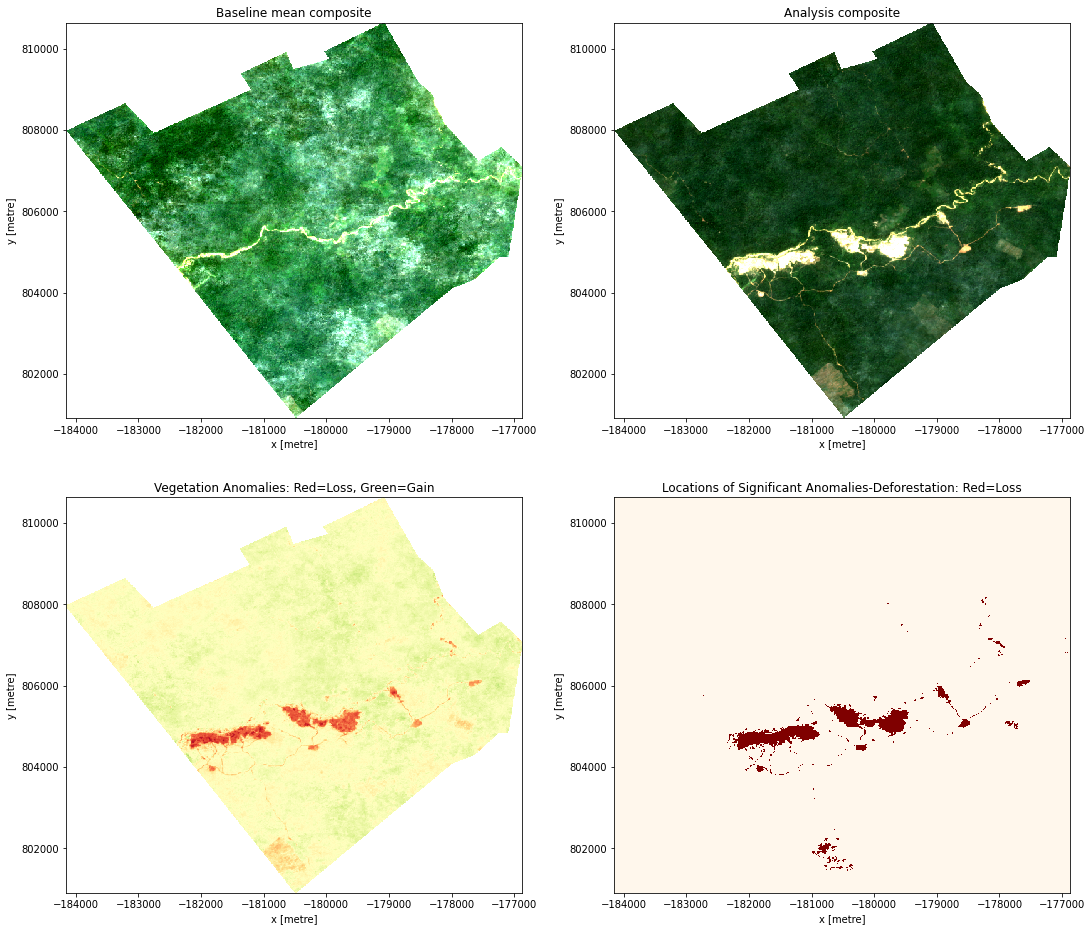

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
baseline[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,0], robust=True)
analysis[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,1], robust=True)
parameter_anomaly.plot(cmap='RdYlGn', ax=ax[1,0], add_colorbar=False)
sig_deforestation.plot(cmap='OrRd', ax=ax[1,1],  add_colorbar=False)
ax[0,0].set_title('Baseline mean composite')
ax[0,1].set_title('Analysis composite')
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain')
ax[1,1].set_title('Locations of Significant Anomalies-Deforestation: Red=Loss')

plt.show()

### Calculate the area per pixel

In [13]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Calculate total area of pixel, area and percentage of vegetation loss pixels

In [14]:
total_pixels = analysis.NDVI.count(dim=['x', 'y']).values
total_deforestation = sig_deforestation.where(sig_deforestation==True).count(dim=['x', 'y']).values

total_forest_area = total_pixels * area_per_pixel
deforestation_area = total_deforestation * area_per_pixel
percentage_deforestation = (total_deforestation/total_pixels) * 100

print(f"Total Area: {total_forest_area:.2f} km sq")
print(f"Deforestation : {deforestation_area:.2f} km sq")
print(f"{percentage_deforestation:.2f}% of pixels likely underwent deforestation")

Total Area: 36.26 km sq
Deforestation : 1.19 km sq
3.28% of pixels likely underwent deforestation


## Determine the change in water extent using WOFS and MNDWI

### Load WOfS data

As we want the time and spatial extents to match the vegetation change data, we can use the same query defined above.

In [15]:
query['resolution'] =  (-30, 30)
query['time'] = (f'{baseline_year}')
ds_wofs_baseline = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs='EPSG:6933',
             fuse_func=wofs_fuser,
             **query
            )

query['time'] = (f'{analysis_year}')
ds_wofs_analysis = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs='EPSG:6933',
             fuse_func=wofs_fuser,
             **query
            )

### Select "water" pixels from the WOFS dataset

WOfS uses bit flags to identify water and non-water pixels. Water pixels have the value `128`. See [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) for more information.

In [16]:
ds_water_baseline = ds_wofs_baseline.water.isin([128])

ds_water_analysis = ds_wofs_analysis.water.isin([128])

if vector_file:
    ds_water_baseline = ds_water_baseline.where(mask)
    
    ds_water_analysis = ds_water_analysis.where(mask)

### Calculate the area per pixel

In [17]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Calculate area covered by water

In [18]:
ds_water_area_baseline = ds_water_baseline.sum(dim=['x', 'y']) * area_per_pixel

ds_water_area_analysis = ds_water_analysis.sum(dim=['x', 'y']) * area_per_pixel

### Select maximum water observed for the two years

In [19]:
baseline_max_water, analysis_max_water = max(ds_water_area_baseline),  max(ds_water_area_analysis)

max_water_baseline = ds_water_baseline.sel(time=baseline_max_water.time.values)

max_water_analysis = ds_water_analysis.sel(time=analysis_max_water.time.values)

### Determine the changes in water over the two periods using WOfS

In [20]:
# The dataset array is transform to 1 and 0 using the `astype(int)` function.
change = max_water_analysis.astype(int) - max_water_baseline.astype(int)

#The various scenarios are extracted from the `change` variable for the two years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (max_water_analysis.astype(int) == 1))

#Water loss = -1
water_disappeared = change.where(change == -1)

### Plot the change over the two periods

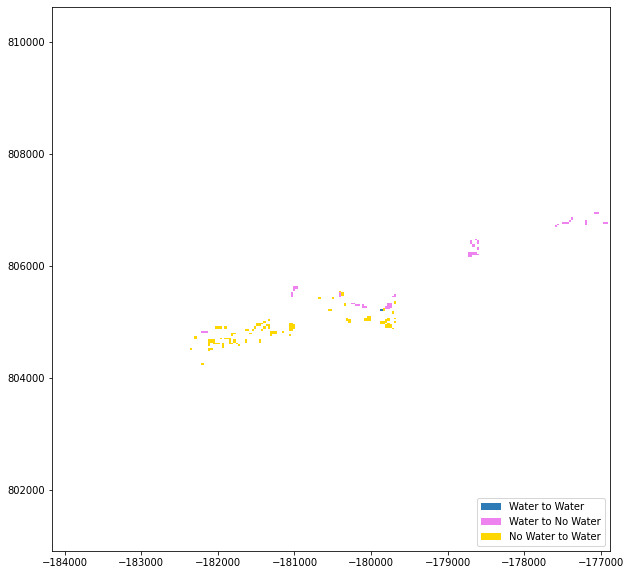

In [21]:
water_appeared_color = 'Gold'
water_disappeared_color = 'Violet'
stable_color = '#2c7bb6'
vegetation_loss = 'Red'
vegetation_gain = 'Green'

plt.figure(figsize=(10, 10))
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [ Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Water to Water', 'Water to No Water' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'lower right'
    )

### Plotting vegetation change and the WOfS 

Text(0.5, 1.0, 'Possible Mining Areas using Vegetation Loss and WOFS)')

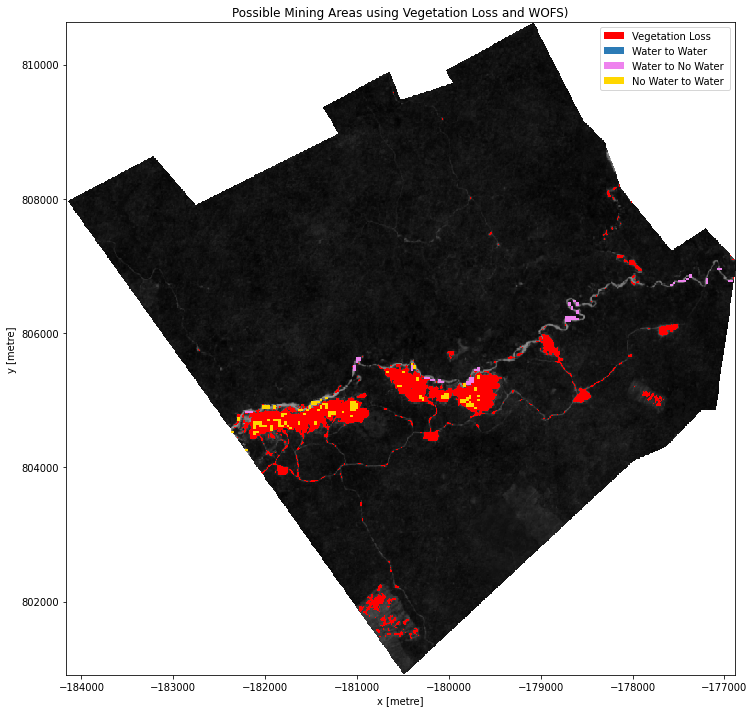

In [22]:
plt.figure(figsize=(12, 12))

analysis.NDVI.plot.imshow(cmap='Greys', add_colorbar=False)
sig_deforestation.where(sig_deforestation==True).plot.imshow(cmap=ListedColormap([vegetation_loss]), add_colorbar=False)
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=vegetation_loss), Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Vegetation Loss','Water to Water', 'Water to No Water ' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'upper right'
    )

plt.title('Possible Mining Areas using Vegetation Loss and WOFS)')

### Determine the changes in water over the two periods using MNDWI
Area where WOFS is not able to observe water, MNDWI can be used as a substitute to those area

In [23]:
# A threshold greater than 0 is  for area where MNDWI indices is water
threshold_value = 0

# We set areas where threshold greater than 0 to 1 and others to 0
analysis_mndwi = xr.where(analysis.MNDWI >= threshold_value, 1, 0)
baseline_mndwi = xr.where(baseline.MNDWI >= threshold_value, 1, 0)

#The change is calculated to determine water gain, loss and permanent
change_mndwi = analysis_mndwi - baseline_mndwi

In [24]:
#Water gain  is 1
mndwi_water_appeared = change_mndwi.where(change_mndwi == 1)

#Permanent water = 0
mndwi_permanent_water = change_mndwi.where((change_mndwi == 0) & (analysis_mndwi == 1))

#Water loss = -1
mndwi_water_disappeared = change_mndwi.where(change_mndwi == -1)

### Plotting vegetation change and MNDWI 

Text(0.5, 1.0, 'Possible Mining Areas using Vegetation Loss and MNDWI')

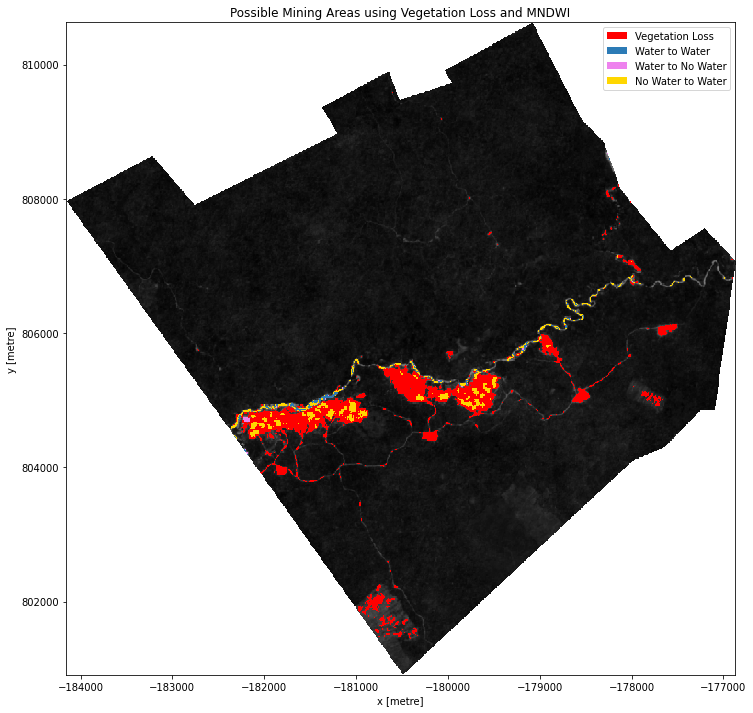

In [25]:
plt.figure(figsize=(12, 12))

analysis.NDVI.plot.imshow(cmap='Greys', add_colorbar=False)
sig_deforestation.where(sig_deforestation==True).plot.imshow(cmap=ListedColormap([vegetation_loss]), add_colorbar=False)
mndwi_water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)
mndwi_water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
mndwi_permanent_water.plot.imshow(cmap=ListedColormap([stable_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=vegetation_loss), Patch(facecolor=stable_color), 
         Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color)], 
        ['Vegetation Loss', 'Water to Water', 'Water to No Water' ,
         'No Water to Water',  'No Water to No water'],
        loc = 'upper right'
    )

plt.title('Possible Mining Areas using Vegetation Loss and MNDWI')

## Next steps


You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google Maps to search for a location you know, then return the latitude and longitude values by clicking the map.



***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [26]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)